In [1]:
# !pip install wget
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import wget 
import os
import zipfile
import itertools
import numpy as np
from numpy import linalg as LA
from matplotlib import pyplot as plt
from datetime import datetime

import cv2
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.applications import vgg16, mobilenet

In [11]:
def download_images(category, path):
    """ If not exists, creates a folder in the current directory with the name of category.
    Downloads each image of the category to this folder."""
    rel_path = path + os.sep + category
    if category not in os.listdir(path):
        os.mkdir(rel_path)
    with open(path + os.sep + f'{category}.csv', 'r') as urls:
        for i, url in enumerate(urls):
            if f"{category}_{i + 1}.jpg" not in os.listdir(rel_path):
                wget.download(url.replace('\n', ''), f"{rel_path}{os.sep}{category}_{i + 1}.jpg")
    return None


def gen_images_classes(path, img_size, n_svd=30):
    """Generates images and classes from folders."""
    images = []
    for category in ['georges', 'non_georges']:
        num_georges = len(images)
        rel_path = path + os.sep + category # path to read from
        image_names = list(filter(
            lambda name: name.startswith(category),
            os.listdir(rel_path)))
        # preserve place for data
        images = images + [_]*len(image_names)
        for i, name in enumerate(image_names):
            img = cv2.imread(rel_path + os.sep + name, 1)
            img = cv2.resize(img, (img_size, img_size))
            # select n_svd main components for each color
            for j in range(3):
                U, s, VT = LA.svd(img[:, :, j]) 
                img[:, :, j] = U[:, :n_svd] @ np.diag(s[:n_svd]) @ VT[:n_svd, :]
            images[num_georges + i] = img
    classes = np.array([[1, 0]]*num_georges + [[0, 1]]*(len(images) - num_georges))
    return np.array(images), classes


def preprocess_images(images, img_size=64, extra_preprocessor=None):
    """Evaluates preprocessing of images. """
    if  extra_preprocessor:
        out_images = extra_preprocessor(images)
    else:
        out_images = [_]*len(images)
        for i, img in enumerate(images):
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (img_size, img_size))
            out_images[i] = img.reshape(img_size, img_size, 1)
        out_images = np.array(out_images)
    return out_images


def create_aug_data(path):
    """Returns augmented train and test data from directories 
    <train_data> and <test_data>."""
    train_generator = ImageDataGenerator(
        rescale = 1./255, rotation_range=15, width_shift_range=0.15,
        height_shift_range=0.15, horizontal_flip=True, zoom_range=0.3,
        preprocessing_function=extra_preprocessor)
    test_generator = ImageDataGenerator(
        rescale = 1./255, preprocessing_function=extra_preprocessor)
    train_set = train_generator.flow_from_directory(
        path + os.sep + 'train_data', target_size=(224, 224),
        batch_size=16, class_mode='binary')
    test_set = test_generator.flow_from_directory(
        path + os.sep + 'test_data', target_size=(224, 224),
        batch_size=16, class_mode='binary')
    return train_set, test_set


def create_adopted_model(Model=mobilenet.MobileNet, epochs=7, verbose=0,
                         learning_rate=0.001, conv_num1=16, conv_num2=32,
                         dense_num=32, l_conv=[0, 0, 0], l_dense=[0, 0, 0]):
    """Creates classification model based on existing one via adding extra layers."""
    # import model
    imported_model = Model(input_shape=(224, 224, 3), include_top=False)
    for layer in imported_model.layers:
        layer.trainable = False
    # add layers
    extra_layers = Conv2D(conv_num1, (3, 3), activation='relu', padding='same',
                          kernel_regularizer=keras.regularizers.l2(l_conv[0]),
                          bias_regularizer=keras.regularizers.l2(l_conv[1]),
                          activity_regularizer=keras.regularizers.l2(l_conv[2]))\
                          (imported_model.output)
    extra_layers = MaxPooling2D(pool_size=(2, 2))(extra_layers)
    extra_layers = Dropout(0.2)(extra_layers)
    extra_layers = Flatten()(extra_layers)
    extra_layers = Dense(dense_num, activation='relu',
                        kernel_regularizer=keras.regularizers.l2(l_dense[0]),
                        bias_regularizer=keras.regularizers.l2(l_dense[1]),
                        activity_regularizer=keras.regularizers.l2(l_dense[2]))\
                        (extra_layers)
    extra_layers = Dropout(0.2)(extra_layers)
    prediction = Dense(2, activation='sigmoid',
                       kernel_regularizer=keras.regularizers.l2(l_dense[0]),
                       bias_regularizer=keras.regularizers.l2(l_dense[1]),
                       activity_regularizer=keras.regularizers.l2(l_dense[2]))\
                       (extra_layers)

    model = keras.models.Model(inputs=imported_model.input, outputs=prediction)
    model.compile(loss='binary_crossentropy',  metrics=['accuracy'],
                  optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
    return model


def create_manual_model(img_size=224, learning_rate=0.001):
    """Creates classification Keras Sequential model."""
    model = Sequential()
    model.add(Conv2D(16, (3, 3), input_shape=(img_size, img_size, 1), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dropout(0.2))

    model.add(Dense(8, kernel_constraint=maxnorm(3), activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',  metrics=['accuracy'],
                  optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
    return model


def my_grid_search(Model, images, classes, param_grid, fixed_params={}, epochs=20):
    """Finds opt hyperparameters of classification model Model from param_grid
    fitting with given images and classes. Params fixed_params are not trainable."""
    max_val_accuracy = 0
    param_values_list = list(itertools.product(*param_grid.values()))
    n = len(param_values_list)
    callback = keras.callbacks.EarlyStopping(
            monitor='loss', patience=3, min_delta=0.01, #mode='min',
            restore_best_weights=True)
    for i, param_values in enumerate(param_values_list):
        params = dict(zip(param_grid.keys(), param_values))
        model = create_adopted_model(Model=Model, **params, **fixed_params)
        history = model.fit(images, classes, validation_split=0.2, 
                            epochs=epochs, verbose=0, callbacks=[callback])
        j, val_accuracy = max(enumerate(history.history['val_accuracy']),
                              key=lambda el: el[1])
        if val_accuracy > max_val_accuracy:
            opt_params = params
            max_val_accuracy = val_accuracy
        # print(params, val_accuracy, history.history['val_loss'][j])
        print(f'\r {(i + 1)/n * 100:.2f} % completed', end='')
    print('\n Best validate accuracy %.4f obtained by params \n %s' % 
          (max_val_accuracy, opt_params))
    return opt_params


def plot_model_history(history, heading):
    """Plots dynamic of accuracy and loss during training."""
    print("\033[1m                    " + heading + "\033[0m")
    for measure in ['accuracy', 'loss']: 
        plt.plot(history.history[measure])
        plt.plot(history.history['val_' + measure])
        plt.title(measure.title() + ' dynamic')
        plt.ylabel(measure)
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='upper left')
        plt.grid()
        plt.show()

In [ ]:
# download images to corresponding foldres if it is necessary
download_images('georges', os.getcwd())
download_images('non_georges', os.getcwd())
# or zip-file could be used
# zip_file = '/content/drive/MyDrive/data.zip'
# zipfile.ZipFile(zip_file, 'r').extractall()

# Saint Georges' classification

Classification of Saint Georges  is going to be solved by three different ways. First consists of creating CNN manually. Other two suppose using ready models such VGG16 and MobileNet. 

In [4]:
# generate images and classes from files
images, classes = gen_images_classes('data/', 224)

## Manual

In [5]:
# creating data for manual model
img_size = 64
images_manual = preprocess_images(images, img_size=img_size)
img_train_manual, img_test_manual, classes_train_manual, classes_test_manual = \
    train_test_split(images_manual, classes, test_size=0.2, random_state=241)

                    MANUAL MODEL


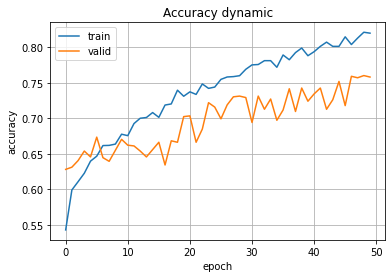

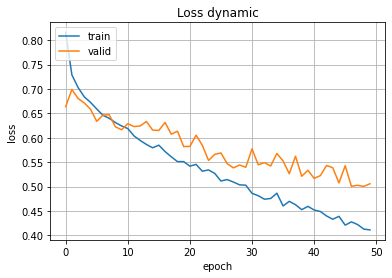

Elapsed time is: 0:00:32.863707


In [12]:
# training manual model
start_time = datetime.now()
model_manual = create_manual_model(img_size, learning_rate=0.0001)
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=0.001)
history_manual = model_manual.fit(
        img_train_manual, classes_train_manual, validation_split=0.2,
        verbose=0, epochs=50, callbacks=[callback])
plot_model_history(history_manual, 'MANUAL MODEL')
print('Elapsed time is:', datetime.now() - start_time)

In [13]:
# prediction on test part
scores = model_manual.evaluate(img_test_manual, classes_test_manual, verbose=0)
print("Accuracy of manual model: %.2f%%" % (scores[1]*100))

Accuracy of manual model: 75.29%


## MobileNet model

In [ ]:
# creating data for MobileNet model 
images_mobilenet = preprocess_image(
    images, extra_preprocessor=mobilenet.preprocess_input)
img_train_mobilenet, img_test_mobilenet, classes_train_mobilenet, classes_test_mobilenet = \
    train_test_split(images_mobilenet, classes, test_size=0.2, random_state=241)

Hyperparameters optimization

In [ ]:
# find opt layers structure
num_units = [5, 10, 20, 30, 60]
param_grid  = {
    'conv_num1': num_units,
    'conv_num2': num_units,
    'dense_num': num_units,
}
opt_params = my_grid_search(
    mobilenet.MobileNet, img_train_mobilenet, classes_train_mobilenet, param_grid)

 100.00 % completed
 Best validate accuracy 0.9039 obtained by params 
 {'conv_num1': 5, 'conv_num2': 60, 'dense_num': 20}


In [ ]:
# find opt convolution regularization parameters 
grid = list(itertools.product(*[[1e-8, 1e-4, 1e-1]]*3))
param_grid  = {'l_conv': grid}
opt_conv_reg_params = my_grid_search(
    mobilenet.MobileNet, img_train_mobilenet, classes_train_mobilenet,
    param_grid, fixed_params=opt_params)

 100.00 % completed
 Best validate accuracy 0.8926 obtained by params 
 {'l_conv': (0.0001, 0.1, 1e-08)}


In [ ]:
# find opt dense regularization parameters 
opt_params['l_conv'] = opt_conv_reg_params['l_conv']
param_grid  = {'l_dense': grid}
opt_dense_reg_params = my_grid_search(
    mobilenet.MobileNet, img_train_mobilenet, classes_train_mobilenet,
    param_grid, fixed_params=opt_params)

 100.00 % completed
 Best validate accuracy 0.9050 obtained by params 
 {'l_dense': (0.1, 0.1, 0.0001)}


Accuracy of MobileNet-based model: 85.95%
                    MOBILENET MODEL


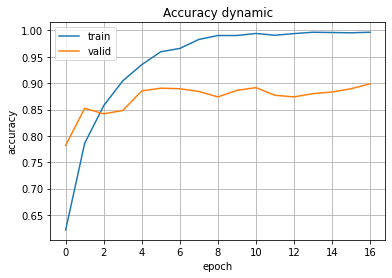

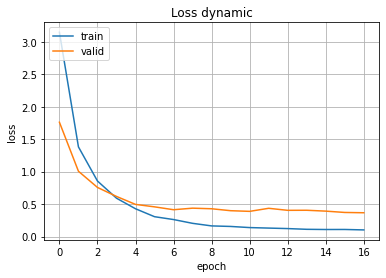

In [ ]:
# train model with opt parameters
opt_params['l_dense'] = opt_dense_reg_params['l_dense']
callback = keras.callbacks.EarlyStopping(
            monitor='loss', patience=3, min_delta=0.01, #mode='min',
            restore_best_weights=True)
model = create_adopted_model(**opt_params)
history = model.fit(
    img_train_mobilenet, classes_train_mobilenet, validation_split=0.2, 
    epochs=20, verbose=0, callbacks=[callback])
scores = model.evaluate(img_test_mobilenet, classes_test_mobilenet, verbose=0)
print("Accuracy of MobileNet-based model: %.2f%%" % (scores[1]*100))
plot_model_history(history, 'MOBILENET MODEL')

## VGG16 model

In [16]:
# creating data for VGG16 model
images_vgg16 = preprocess_images(images, extra_preprocessor=vgg16.preprocess_input)
img_train_vgg16, img_test_vgg16, classes_train_vgg16, classes_test_vgg16 = \
    train_test_split(images_vgg16, classes, test_size=0.2, random_state=241)

Accuracy of vgg16-based model: 82.48%
                    VGG16 MODEL


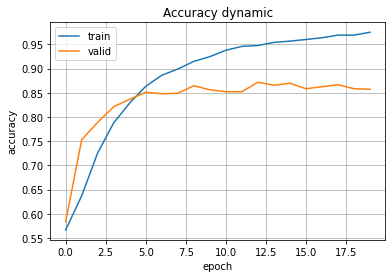

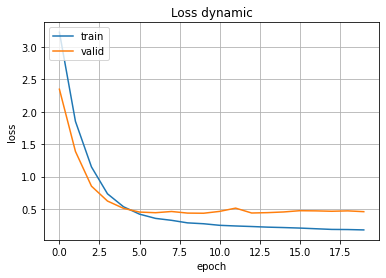

In [18]:
opt_params = {'conv_num1': 5, 'conv_num2': 20, 'dense_num': 20,
              'l_dense': (0.1, 0.1, 0.0001), 'l_conv': (0.0001, 0.1, 1e-08)}
callback = keras.callbacks.EarlyStopping(
            monitor='loss', patience=3, min_delta=0.01, #mode='min',
            restore_best_weights=True)
model = create_adopted_model(Model=vgg16.VGG16, **opt_params)
history = model.fit(
    img_train_vgg16, classes_train_vgg16, validation_split=0.2, 
    epochs=20, verbose=0, callbacks=[callback])
scores = model.evaluate(img_test_vgg16, classes_test_vgg16, verbose=0)
print("Accuracy of vgg16-based model: %.2f%%" % (scores[1]*100))
plot_model_history(history, 'VGG16 MODEL')